# **Week 6 - Capstone Development**

## **Decision Trees and Random Forests**

Our moment has arrived. Finally, we can check the performance of these models against the extreme class imbalance in the target set. 

### **Imports**

In [103]:
# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns
import matplotlib.pyplot as plt



# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    RepeatedKFold
)

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

### **Dataset Imports**

In [2]:
# Base Datasets
BDB_All_Plays_Model_Ready = pd.read_csv("../../BDB_All_Plays_Model_Ready.csv") # Big Data Bowl Dataset
PDA_Model_Ready = pd.read_csv("../../PDA_Model_Ready.csv") # Punt Data Analytics
FNF_Model_Ready = pd.read_csv("../../FNF_Model_Ready.csv") # First and Future


# PCA and Standardized Datasets
PDA_PCA_Features = pd.read_csv('../../Feature_Subsets/PDA_PCA_Features.csv')
FNF_PCA_Features = pd.read_csv('../../Feature_Subsets/FNF_PCA_Features.csv')
BDB_PCA_Features = pd.read_csv('../../Feature_Subsets/BDB_PCA_Features.csv')

### **Useful Functions**

Once again, we will be using the train test split, the run_model_classifier, and the standardize features functions that we obtained originally from Module 3, and have since adapted in the weeks preceeding this. 

### **Train Test Split**

In [6]:
# ===========================================================================================
# Function taken from Module 3 Final Project
# https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Final_Project_Report.ipynb
# ===========================================================================================

def train_test_split_data(df, target_col):
    X = df.drop(columns=target_col)
    y = df[target_col]
# 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

and using it to split the data

In [7]:
PDA_PCA_X_train, PDA_PCA_X_test, PDA_PCA_y_train, PDA_PCA_y_test = train_test_split_data(PDA_PCA_Features, 'Inj_Occured')
FNF_PCA_X_train, FNF_PCA_X_test, FNF_PCA_y_train, FNF_PCA_y_test = train_test_split_data(FNF_PCA_Features, 'Inj_Occured')
BDB_PCA_X_train, BDB_PCA_X_test, BDB_PCA_y_train, BDB_PCA_y_test = train_test_split_data(BDB_PCA_Features, 'Inj_Occured')

bdb_X_train, bdb_X_test, bdb_y_train, bdb_y_test = train_test_split_data(BDB_All_Plays_Model_Ready, 'Inj_Occured')
fnf_X_train, fnf_X_test, fnf_y_train, fnf_y_test = train_test_split_data(FNF_Model_Ready, 'Inj_Occured')
pda_X_train, pda_X_test, pda_y_train, pda_y_test = train_test_split_data(PDA_Model_Ready, 'Inj_Occured')


#### **Standardization Function**

In [3]:
# =============================================================================================
# Standardize Numeric Features
#
# Taken from Week 2.ipynb and modified to exclude the hard coded logic
#  
# Originally taken from Mod 3 final project found here: 
# https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Final_Project_Report.ipynb
#
# =============================================================================================


def standardize_features(df, target_column=None, debug=False, return_scaler=False):
    df_scaled = df.copy()

    # 1) Automatically detect numeric columns
    numeric_cols = df.select_dtypes(include="number").columns.tolist()

    # 2) Remove target if present
    if target_column in numeric_cols:
        numeric_cols.remove(target_column)

    # 3) Exclude binary (0/1) columns
    numeric_cols_to_scale = [
        col for col in numeric_cols
        if df[col].nunique(dropna=True) > 2
    ]

    if debug:
        print("Numeric columns before filtering:", numeric_cols)
        print("Numeric columns after filtering:", numeric_cols_to_scale)

    # 4) Apply StandardScaler
    scaler = StandardScaler()
    if numeric_cols_to_scale:
        df_scaled[numeric_cols_to_scale] = scaler.fit_transform(df_scaled[numeric_cols_to_scale])

    if return_scaler:
        return df_scaled, scaler
    return df_scaled

And using this to scale our feature sets. 

In [8]:
PDA_PCA_X_train_scaled = standardize_features(PDA_PCA_X_train)
PDA_PCA_X_test_scaled = standardize_features(PDA_PCA_X_test)
# PDA_PCA_y_train
# PDA_PCA_y_test 


FNF_PCA_X_train_scaled = standardize_features(FNF_PCA_X_train) 
FNF_PCA_X_test_scaled = standardize_features(FNF_PCA_X_test)
# FNF_PCA_y_train
# FNF_PCA_y_test 

BDB_PCA_X_train_scaled = standardize_features(BDB_PCA_X_train)
BDB_PCA_X_test_scaled  = standardize_features(BDB_PCA_X_test)
# BDB_PCA_y_train
# BDB_PCA_y_test 

bdb_X_train_scaled = standardize_features(bdb_X_train)
bdb_X_test_scaled = standardize_features(bdb_X_test)
# bdb_y_train
# bdb_y_test 

fnf_X_train_scaled = standardize_features(fnf_X_train)
fnf_X_test_scaled = standardize_features(fnf_X_test)
# fnf_y_train
# fnf_y_test 

pda_X_train_scaled = standardize_features(pda_X_train)
pda_X_test_scaled = standardize_features(pda_X_test)
# pda_y_train
# pda_y_test 

### **Run Model Classifier**

In [9]:
# =============================================================================================
# Taken from Mod 3 Week 8:
# https://github.com/waysnyder/Module-3-Assignments/blob/main/Homework_08.ipynb
# 
# Global dataframe logic taken from mod 3 final project: 
# https://github.com/LeeMcFarling/Final_Project_Writeup/blob/main/Final_Project_Report.ipynb
# 
# Final Function was developed in Week 2 of this Module
# =============================================================================================

def run_model_classifier(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, run_comment=None, return_model=False, concat_results=False, **model_params):

    global combined_results
    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    model_name = model.__name__ if isinstance(model, type) else model.__class__.__name__ # Added because 


    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    test_preds     = model.predict(X_test)

    # Normal Accuracy 
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy  = accuracy_score(y_test, test_preds)

    # Balanced Accuracy Metrics
    balanced_train_accuracy = balanced_accuracy_score(y_train, train_preds)
    balanced_test_accuracy = balanced_accuracy_score(y_test, test_preds)

    results_df = pd.DataFrame([{
        'model': model_name, 
        'model_params': model.get_params(),
        'mean_cv_accuracy': mean_cv_accuracy,
        'std_cv_accuracy': std_cv_accuracy,
        'train_accuracy': train_accuracy, 
        'test_accuracy': test_accuracy,
        'balanced_train_accuracy' : balanced_train_accuracy,
        'balanced_test_accuracy': balanced_test_accuracy,
        'run_comment': run_comment
    }])
    
    if concat_results:
        try:
            combined_results = pd.concat([combined_results, results_df], ignore_index=True)
        except NameError:
            combined_results = results_df

    return (results_df, model) if return_model else results_df

### **Parameter Sweep**

In [73]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
        
    # Instantiate the model if a class is provided
    if isinstance(model, type):
        model = model(**model_params)
    else:                                    
        model.set_params(**model_params)    

    # Use RepeatedStratifiedKFold for classification to preserve class distribution
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    
    # Perform 5-fold cross-validation using accuracy as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, scoring='balanced_accuracy', cv=cv, n_jobs=n_jobs)
    
    mean_cv_accuracy = np.mean(cv_scores)
    std_cv_accuracy  = np.std(cv_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training and testing accuracy
    train_preds    = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds     = model.predict(X_test)
    test_accuracy  = accuracy_score(y_test, test_preds)
    
    return mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy


In [82]:
# ===============================================================================================
# From Module 3 Week 8: 
# link: https://github.com/waysnyder/Module-3-Assignments/blob/main/Homework_08.ipynb
# ===============================================================================================

def sweep_parameter(
    model,
    Parameters,
    param,
    parameter_list,
    *,
    X_train,
    y_train,
    X_test,
    y_test,
    verbose=True,
    n_iter_no_change=None,
    delta=0.001,
    n_jobs=-1,
    n_repeats=10,
):
    import time
    import numpy as np
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    start = time.time()
    Parameters = Parameters.copy()  # don’t mutate caller’s dict

    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf

    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        P_temp = Parameters.copy()
        P_temp[param] = p
        P_temp.pop('accuracy_found', None)
        # P_temp.pop('n_jobs', None)

        # run_model should return: mean_cv, std_cv, train_acc, test_acc
        mean_cv, std_cv, train_acc, test_acc = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )

        cv_accuracies.append(mean_cv)
        std_cvs.append(std_cv)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if mean_cv > best_accuracy + delta:
            best_accuracy = mean_cv
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            if verbose:
                print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy

    if verbose:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

        partial_param_list = parameter_list[:len(cv_accuracies)]
        is_boolean = all(isinstance(v, bool) for v in partial_param_list)
        x_vals = list(range(len(partial_param_list))) if is_boolean else partial_param_list
        x_labels = [str(v) for v in partial_param_list]

        ax1.set_title(f"Accuracy vs {param}")
        ax1.plot(x_vals, cv_accuracies, marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals, train_accuracies, marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals, test_accuracies, linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]], [max_cv_accuracy], marker='x', label="Best CV", color='red')
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()

        ax2.set_title(f"CV Std vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Std")
        ax2.legend()
        ax2.grid(alpha=0.5)
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters

____

## **Decision Trees**

## Appendix: Which DecisionTree parameters are most important?

When first exploring  a complex model such as decision trees, it’s best to focus first on those parameters that most directly affect the shape of the tree and the method used for splitting nodes. Some parameters are more important than others, especially when first using a model. Here is an approximate ordering of the parameters from most significant to least. We will only experiment with the first 4 of these parameters in this homework. 

---

1. **max_depth** (default: **None**)  
   *Controls the maximum depth of the tree, which is crucial for managing overfitting and overall model complexity.*

2. **max_leaf_nodes** (default: **None**)  
   *An alternative to max_depth, this limits the number of leaf nodes and can be used to control tree size in a different way.*

3. **max_features** (default: **None**)  
   *Determines the maximum number of features considered when looking for the best split. Tuning this can affect the bias-variance trade-off.*

4. **min_samples_split** (default: **2**)  
   *Specifies the minimum number of samples required to split an internal node. It influences how “greedy” the tree is in creating splits.*

---

5. **criterion** (default: **'squared_error'**)  
   *Chooses the function to measure the quality of a split (e.g., squared_error, absolute_error, etc.). Experimenting with this can reveal how different error metrics impact performance.*

6. **splitter** (default: **'best'**)  
   *Decides the strategy used to choose the split at each node (typically "best" or "random"). While its effect is subtler, exploring it can be educational.*

7. **min_samples_leaf** (default: **1**)  
   *Sets the minimum number of samples that must be present in a leaf. This parameter helps prevent creating leaves with very few samples, thus reducing overfitting.*


8. **ccp_alpha** (default: **0.0**)  
   *The complexity parameter for Minimal Cost-Complexity Pruning. It’s useful for understanding pruning techniques, though it’s a bit more advanced.*

9. **min_impurity_decrease** (default: **0.0**)  
   *A node will be split only if the split results in a decrease in impurity greater than or equal to this threshold. It provides another way to control overfitting.*

10. **min_weight_fraction_leaf** (default: **0.0**)  
    *Ensures that each leaf has a minimum weighted fraction of the total. It’s less commonly tuned but can be relevant when sample weights matter.*

11. **random_state** (default: **None**)  
    *Used only for reproducibility, traditionally as `random_state = 42`. It doesn’t affect the model’s learning, but ensures that results are consistent across runs. Set to `None` for more realistic random behavior typical for deployed systems. 

#### **Parameter Sweeps for Decision Tree**

1. Max Depth

Sweeping max_depth: 100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


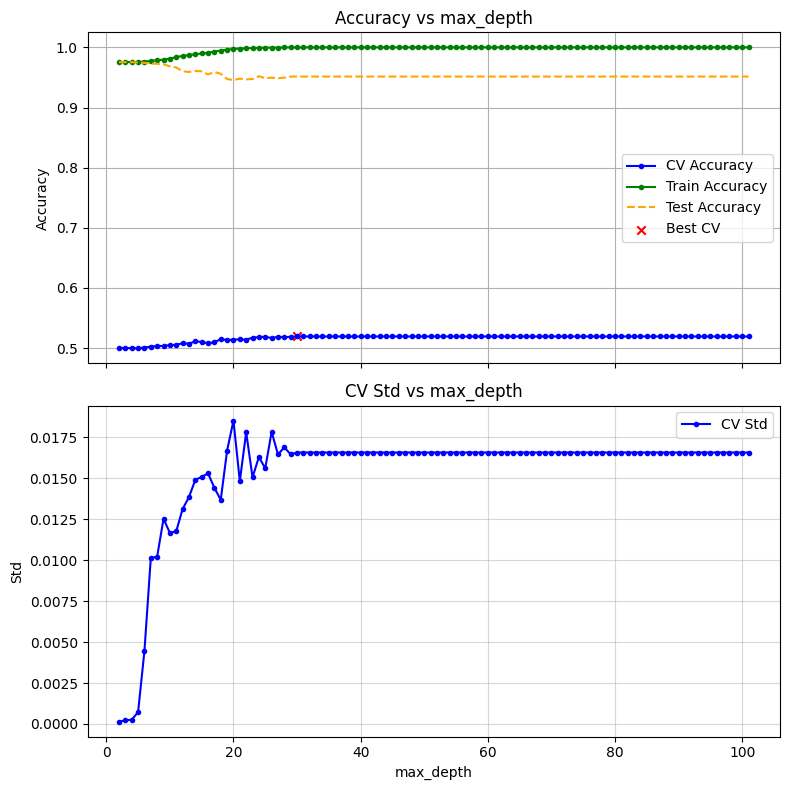

Execution Time: 00:00:30


In [34]:
best_params = sweep_parameter(
    model=DecisionTreeClassifier,
    Parameters={'criterion': 'gini', 'random_state': 42},
    param='max_depth',
    parameter_list=list(range(2, 102)),
    X_train=bdb_X_train_scaled,
    y_train=bdb_y_train,
    X_test=bdb_X_test_scaled,
    y_test=bdb_y_test,
    n_repeats=5,
    n_jobs=-1,
)

2. Max Leaf Nodes

Sweeping max_leaf_nodes: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


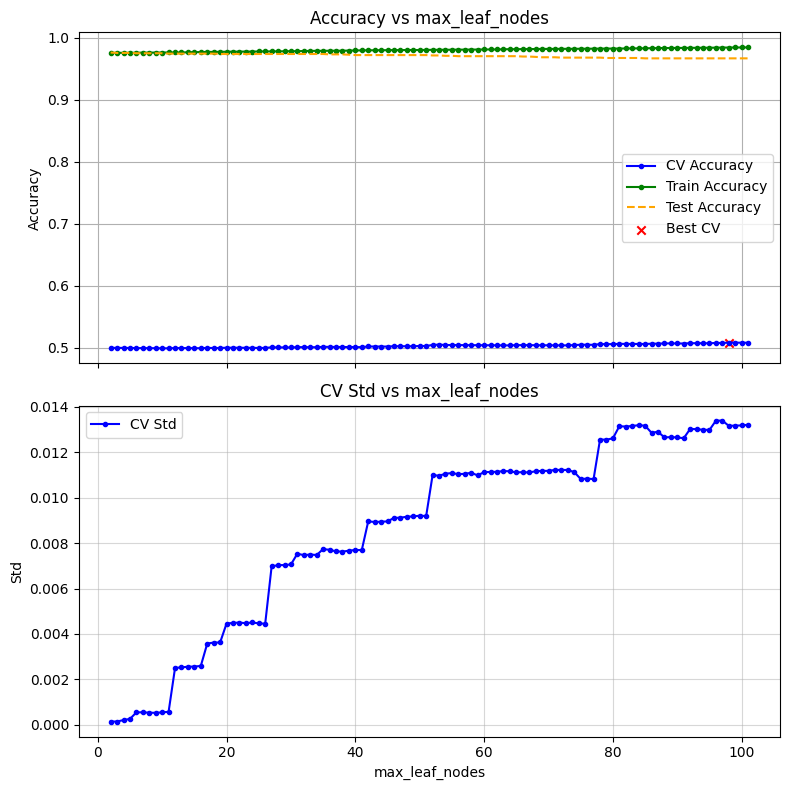

Execution Time: 00:00:23


In [36]:
best_params = sweep_parameter(
    model=DecisionTreeClassifier,
    Parameters={'criterion': 'gini', 'random_state': 42},
    param='max_leaf_nodes',
    parameter_list=list(range(2, 102)),
    X_train=bdb_X_train_scaled,
    y_train=bdb_y_train,
    X_test=bdb_X_test_scaled,
    y_test=bdb_y_test,
    n_repeats=5,
    n_jobs=-1,
)

3. Max Features

Sweeping max_features: 100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


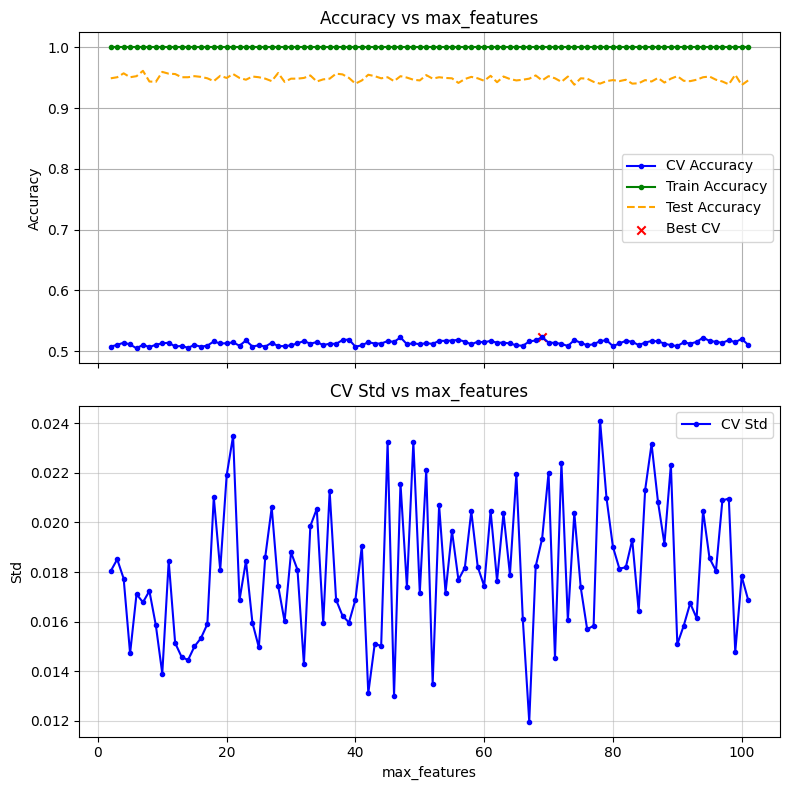

Execution Time: 00:00:23


In [38]:
best_params = sweep_parameter(
    model=DecisionTreeClassifier,
    Parameters={'criterion': 'gini', 'random_state': 42},
    param='max_features',
    parameter_list=list(range(2, 102)),
    X_train=bdb_X_train_scaled,
    y_train=bdb_y_train,
    X_test=bdb_X_test_scaled,
    y_test=bdb_y_test,
    n_repeats=5,
    n_jobs=-1,
)

4) Min Samples Split

Sweeping min_samples_split: 100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


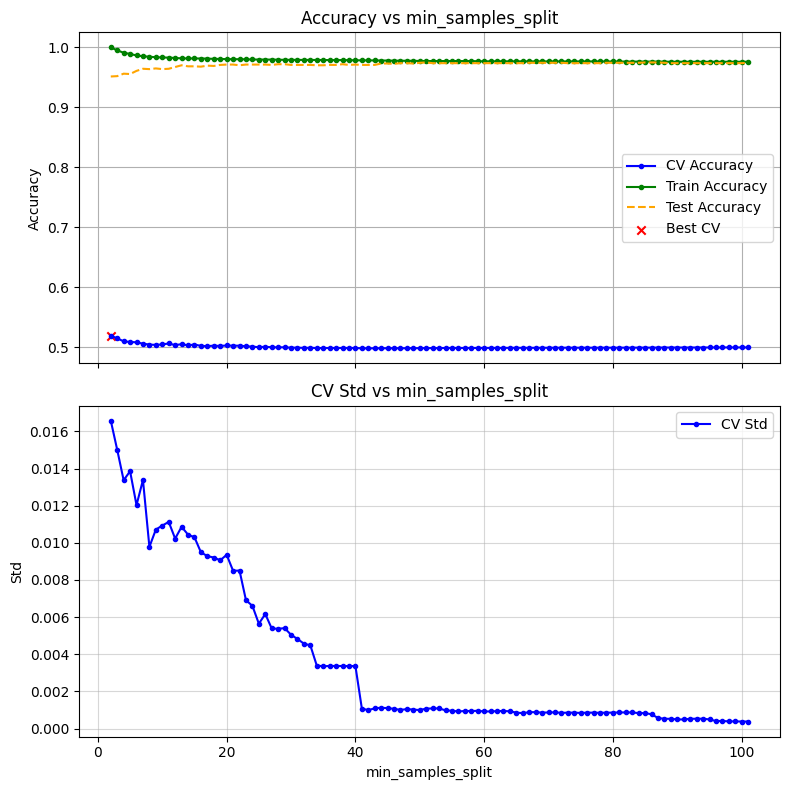

Execution Time: 00:00:31


In [39]:
best_params = sweep_parameter(
    model=DecisionTreeClassifier,
    Parameters={'criterion': 'gini', 'random_state': 42},
    param='min_samples_split',
    parameter_list=list(range(2, 102)),
    X_train=bdb_X_train_scaled,
    y_train=bdb_y_train,
    X_test=bdb_X_test_scaled,
    y_test=bdb_y_test,
    n_repeats=5,
    n_jobs=-1,
)


from sklearn.ensemble        import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier


... well that isn't going well.. I switched it to 'balanced accuracy' becuase it was overfitting. (This is the most balanced of the datasets, because the accuracy was surprise surprise overfitting, I'm just gonna run this model once, because it seems like it's overfitting and we'd be better off concentrating more effort on a random forest. 

In [48]:
params_ = {
    'max_depth' : 20, 
    'max_leaf_nodes' : 60, 
    'max_features' : 70,
    'min_samples_split' : 5,
    'random_state' : 42,
}

BDB_Decision_Tree_Tuned = run_model_classifier(
    DecisionTreeClassifier,
    bdb_X_train_scaled, 
    bdb_y_train, 
    bdb_X_test_scaled,
    bdb_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB - Decision Tree - Tuned', 
    return_model=False,
    concat_results=True,
    **params_
    )

BDB_Decision_Tree_Tuned

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.969001,0.002206,0.979822,0.97076,0.60325,0.497006,BDB - Decision Tree - Tuned


Yup, yikes that's really overfitting -- let's move on to random forests and ensemble models to see if we can't get a better balanced Test accuracy. 

____

## **Random Forest Parameter Sweep**

In [42]:
Default_Parameters_RandomForest = {
    'n_estimators'           : 100,     # Number of trees in the forest
    'criterion'              : 'gini',  # Function to measure quality of a split ('gini' or 'entropy')
    'max_depth'              : None,    # Maximum depth of the tree (None means nodes are expanded until leaves are pure)
    'min_samples_split'      : 2,       # Minimum number of samples required to split an internal node
    'min_samples_leaf'       : 1,       # Minimum number of samples required to be at a leaf node
    'min_weight_fraction_leaf': 0.0,    # Minimum weighted fraction of the sum total of weights required to be at a leaf node
    'max_features'           : 'sqrt',  # Number of features to consider when looking for the best split
    'max_leaf_nodes'         : None,    # Maximum number of leaf nodes
    'min_impurity_decrease'  : 0.0,     # Threshold for a node to split further based on impurity
    'bootstrap'              : True,    # Whether bootstrap samples are used when building trees
    'oob_score'              : False,   # Whether to use out-of-bag samples to estimate accuracy
    'verbose'                : 0,       # Controls the verbosity when fitting and predicting
    'warm_start'             : False,   # Reuse the solution of the previous call to fit and add more estimators
    'class_weight'           : None,    # Weights associated with classes (None means all classes have weight=1)
    'ccp_alpha'              : 0.0,     # Complexity parameter for minimal cost-complexity pruning
    'max_samples'            : None,     # Number of samples to draw from X to train each base estimator (if bootstrap=True)
    'random_state'           : 42
}

In [43]:
Parameters_RF = Default_Parameters_RandomForest.copy()
Params_RF_List = []

Sweeping n_estimators: 100%|██████████| 49/49 [01:42<00:00,  2.09s/it]


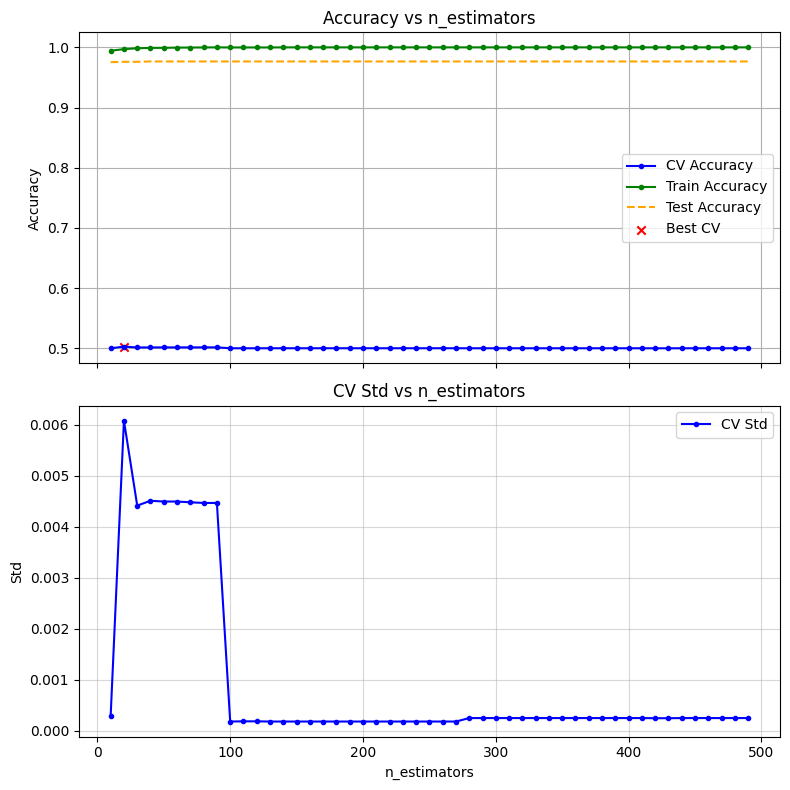

Execution Time: 00:01:42


Sweeping max_depth: 100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


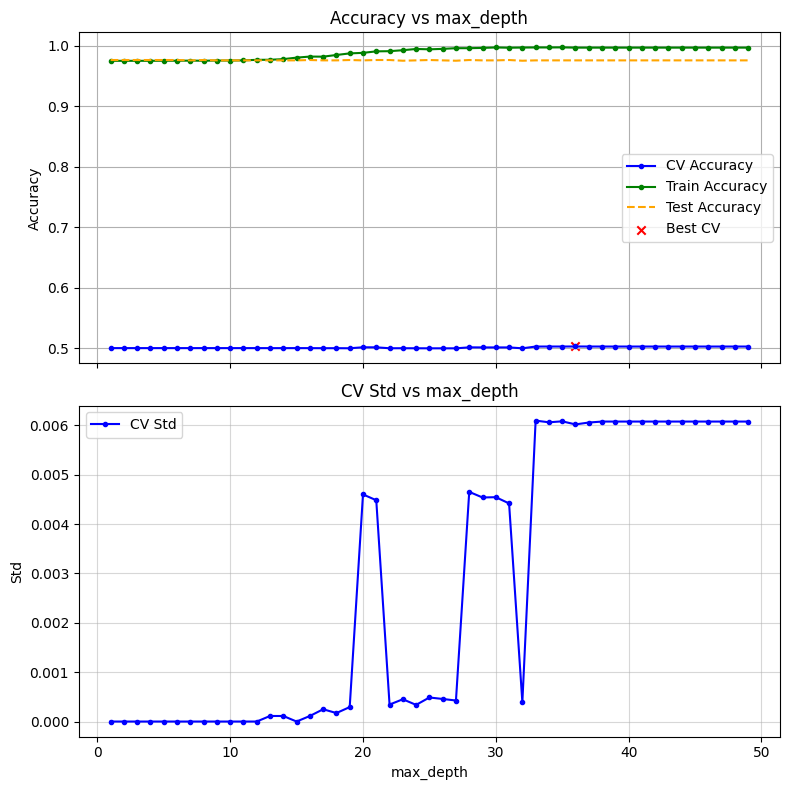

Execution Time: 00:00:14


Sweeping max_samples: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


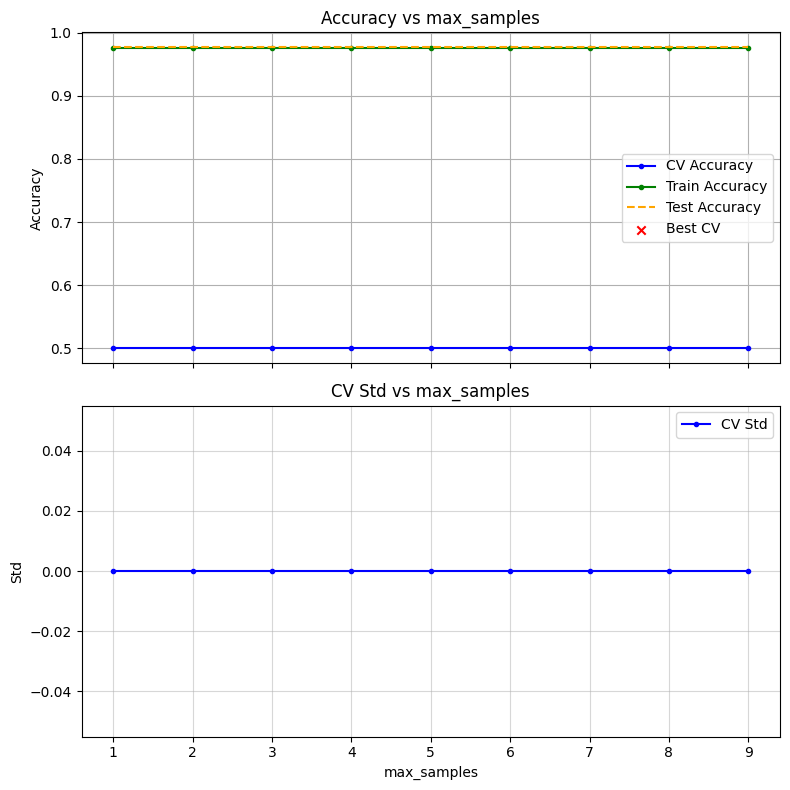

Execution Time: 00:00:01


,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,max_leaf_nodes,min_impurity_decrease,bootstrap,oob_score,verbose,warm_start,class_weight,ccp_alpha,max_samples,random_state,accuracy_found
0,20,gini,36,2,1,0.0,sqrt,None,0.0,True,False,0,False,None,0.0,None,42,0.502723


In [45]:
start = time.time()

parameters_and_ranges = [
    ('n_estimators', range(10, 500, 10)),
    ('max_depth', [None] + list(range(1, 50, 1))),
    ('max_samples', [None] + list(range(1, 10, 1))),
    # ('max_iter', range(100,10001, 100)),
]

for param, parameter_list in parameters_and_ranges:
    Parameters_RF = sweep_parameter(
        RandomForestClassifier,      # or your model class
        Parameters_RF,          # renamed variable here
        param,
        parameter_list,
        X_train=bdb_X_train_scaled,
        y_train=bdb_y_train,
        X_test=bdb_X_test_scaled,
        y_test=bdb_y_test,
        n_jobs=-1,
        n_repeats=2
    )

Params_RF_List.append(Parameters_RF)
pd.DataFrame(Params_RF_List)

In [47]:
params_ = {
    'n_estimators' : 20, 
    'criterion' : 'gini', 
    'max_depth' : 36,
    'min_samples_split' : 2,
    'random_state' : 42,
}

BDB_Random_Forest_Tuned = run_model_classifier(
    RandomForestClassifier,
    bdb_X_train_scaled, 
    bdb_y_train, 
    bdb_X_test_scaled,
    bdb_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB - Random Forest - Tuned', 
    return_model=False,
    concat_results=True,
    **params_
    )

BDB_Random_Forest_Tuned

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.974996,0.000713,0.997076,0.976023,0.940828,0.499701,BDB - Random Forest - Tuned


Oof and again we're overfitting. Let's switch gears here and look for models that are built for this king of imbalance.

In [84]:
combined_results

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.974996,0.000713,0.997076,0.976023,0.940828,0.499701,BDB - Random Forest - Tuned
1,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.969001,0.002206,0.979822,0.970760,0.603250,0.497006,BDB - Decision Tree - Tuned


____

### **BalancedBaggingClassifier**

- https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedBaggingClassifier.html


The imblementation is similar to bagging trees classifier from SK learn but it is built for this kind of extreme imbalance. It has hyperparameters that aim to re-sample the classes so that they are more aligned with each other. 

First had to edit the sweep_parameter function to deduplicate the n_jobs since this class has an n_jobs baked in: 

In [83]:
# ===============================================================================================
# From Module 3 Week 8: 
# link: https://github.com/waysnyder/Module-3-Assignments/blob/main/Homework_08.ipynb
# ===============================================================================================

def sweep_parameter(
    model,
    Parameters,
    param,
    parameter_list,
    *,
    X_train,
    y_train,
    X_test,
    y_test,
    verbose=True,
    n_iter_no_change=None,
    delta=0.001,
    n_jobs=-1,
    n_repeats=10,
):
    import time
    import numpy as np
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    start = time.time()
    Parameters = Parameters.copy()  # don’t mutate caller’s dict

    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf

    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        P_temp = Parameters.copy()
        P_temp[param] = p
        P_temp.pop('accuracy_found', None)
        P_temp.pop('n_jobs', None)

        # run_model should return: mean_cv, std_cv, train_acc, test_acc
        mean_cv, std_cv, train_acc, test_acc = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )

        cv_accuracies.append(mean_cv)
        std_cvs.append(std_cv)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if mean_cv > best_accuracy + delta:
            best_accuracy = mean_cv
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            if verbose:
                print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy

    if verbose:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

        partial_param_list = parameter_list[:len(cv_accuracies)]
        is_boolean = all(isinstance(v, bool) for v in partial_param_list)
        x_vals = list(range(len(partial_param_list))) if is_boolean else partial_param_list
        x_labels = [str(v) for v in partial_param_list]

        ax1.set_title(f"Accuracy vs {param}")
        ax1.plot(x_vals, cv_accuracies, marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals, train_accuracies, marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals, test_accuracies, linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]], [max_cv_accuracy], marker='x', label="Best CV", color='red')
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()

        ax2.set_title(f"CV Std vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Std")
        ax2.legend()
        ax2.grid(alpha=0.5)
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters

And here are the default params from the documentation

In [ ]:
Default_Parameters_BalancedBagging = {
    'estimator'            : None,        # Base estimator to fit on balanced bootstrap samples (e.g., DecisionTreeClassifier)
    'n_estimators'         : 10,          # Number of base estimators in the ensemble
    'max_samples'          : 1.0,         # Number (int) or proportion (float) of samples to draw from X to train each base estimator
    'max_features'         : 1.0,         # Number (int) or proportion (float) of features to draw for each base estimator
    'bootstrap'            : True,        # Whether samples are drawn with replacement (bootstrap)
    'bootstrap_features'   : False,       # Whether features are drawn with replacement
    'oob_score'            : False,       # Whether to use out-of-bag samples to estimate generalization error
    'warm_start'           : False,       # Reuse solution from previous fit and add more estimators
    'sampling_strategy'    : 'auto',      # Sampling strategy for balancing the classes ('auto' balances to equal class sizes)
    'replacement'          : False,       # Whether sampling of minority/majority classes is done with replacement
    'n_jobs'               : None,        # Number of CPU cores to use for fitting (-1 uses all)
    'random_state'         : 42,          # Random seed for reproducibility
    'verbose'              : 0,           # Verbosity level (higher = more output)
    'sampler'              : None         # Optional sampler object for custom resampling behavior (e.g., SMOTE, RandomUnderSampler)
}


In [63]:
Parameters_BBC = Default_Parameters_BalancedBagging.copy()
Params_BBC_List = []

Sweeping n_estimators: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


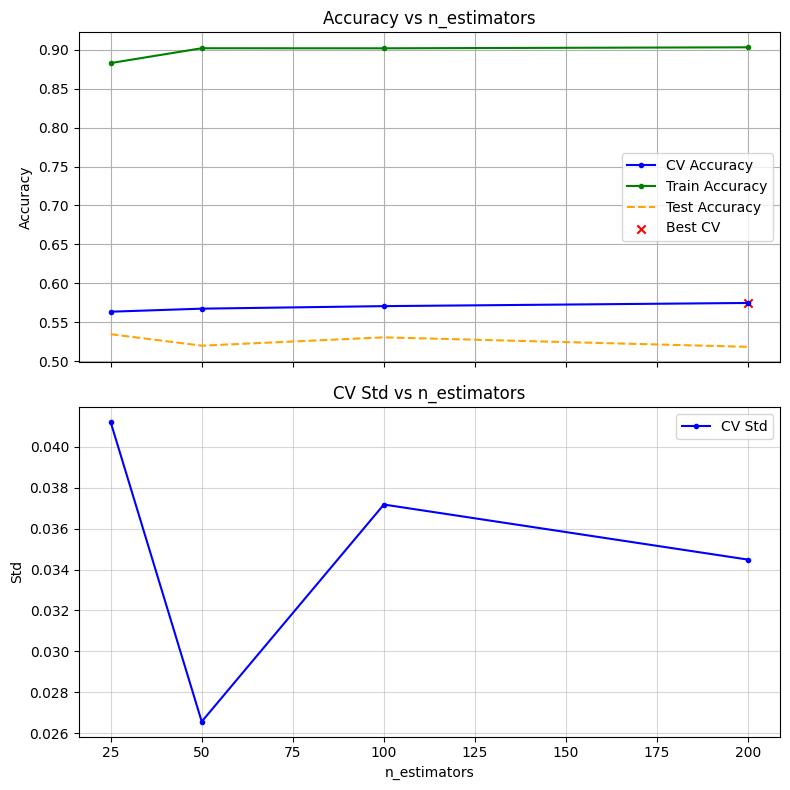

Execution Time: 00:00:04


Sweeping max_samples: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


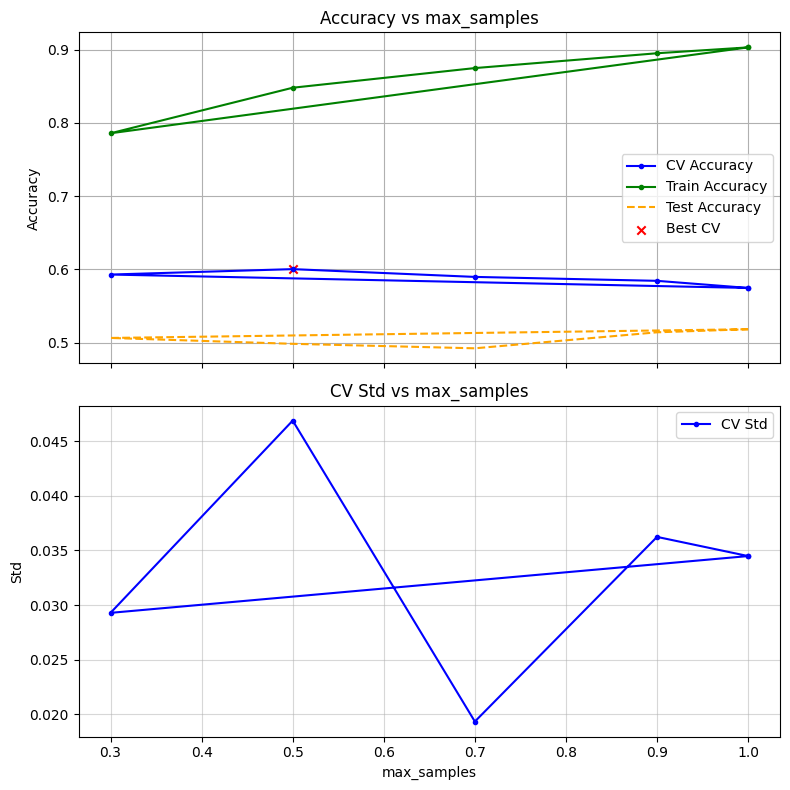

Execution Time: 00:00:09


Sweeping max_features: 100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


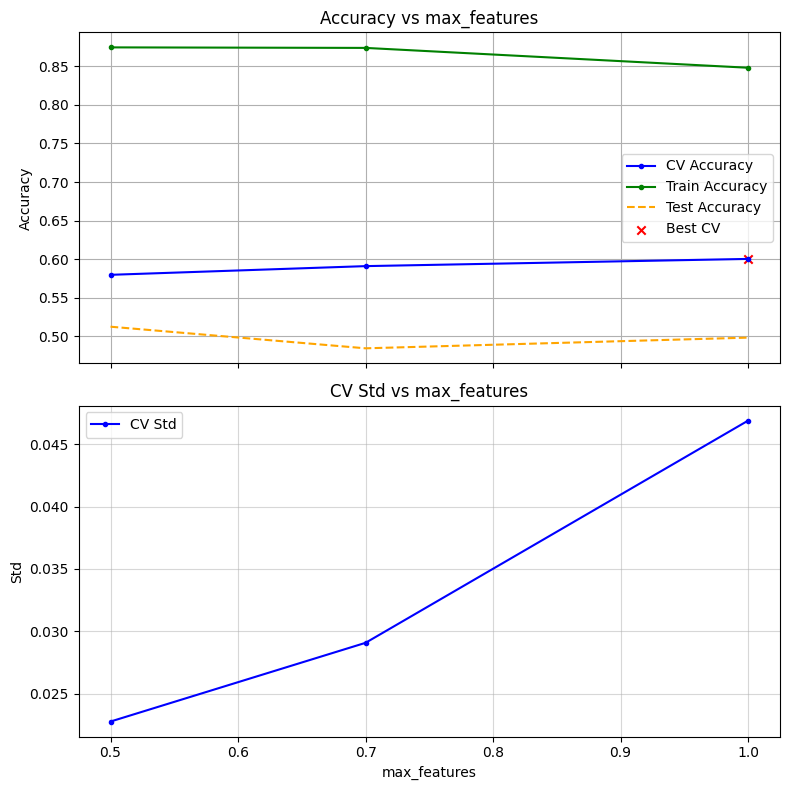

Execution Time: 00:00:04


Sweeping replacement: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


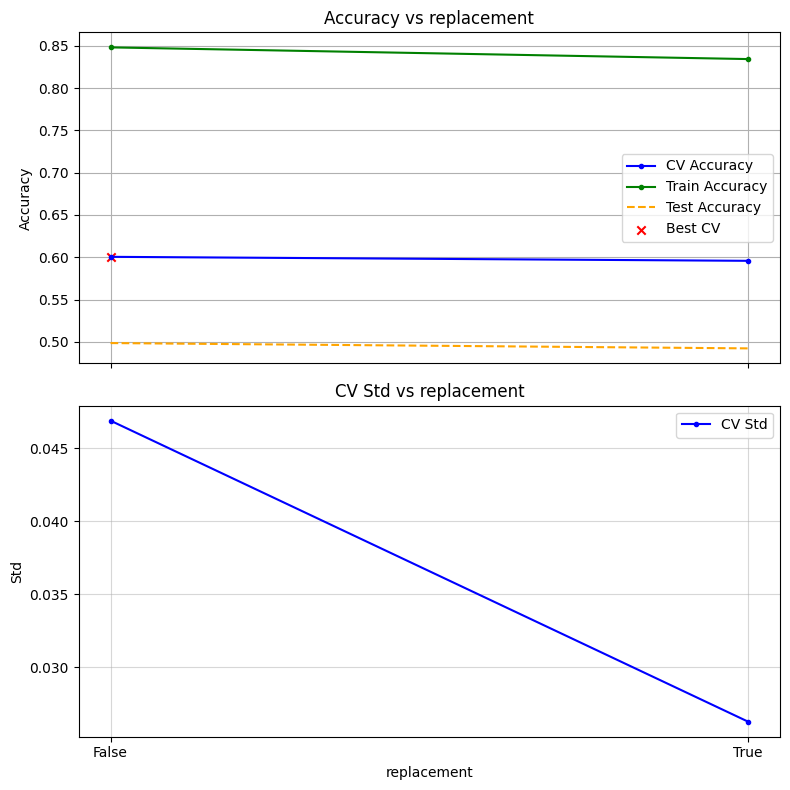

Execution Time: 00:00:02


Sweeping sampling_strategy: 100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


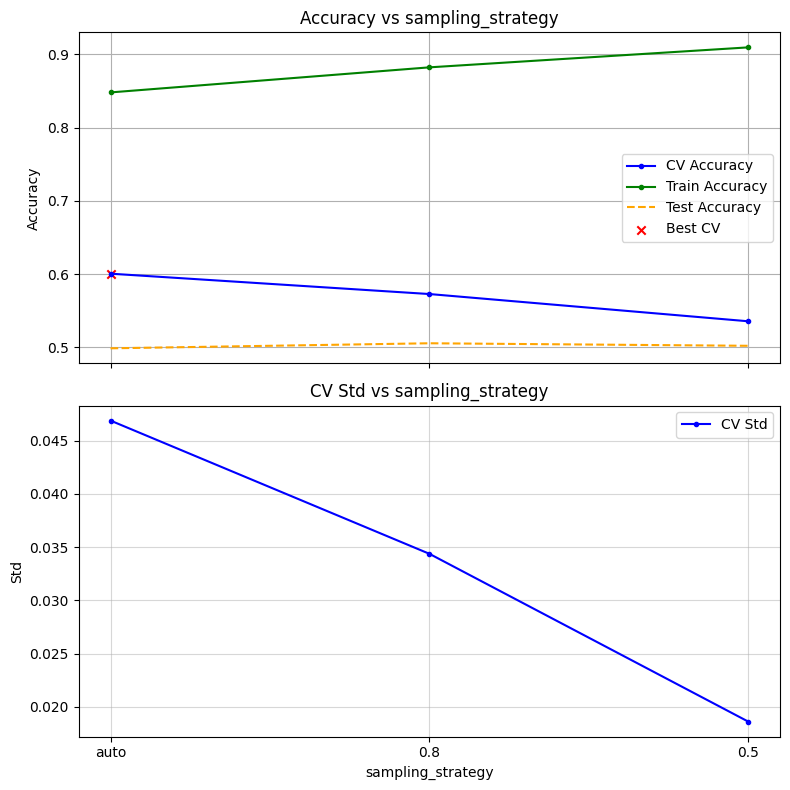

Execution Time: 00:00:04


,estimator,n_estimators,max_samples,max_features,bootstrap,bootstrap_features,oob_score,warm_start,sampling_strategy,replacement,n_jobs,random_state,verbose,sampler,accuracy_found
0,None,200,0.5,1.0,True,False,False,False,auto,False,None,42,0,None,0.600474


In [81]:

frac_samples = [0.3, 0.5, 0.7, 0.9, 1.0]
frac_features = [0.5, 0.7, 1.0]

parameters_and_ranges = [
    # Decision Tree Estimator Knobs
    ('n_estimators',               [25, 50, 100, 200]),
    # Bagging and Sampling Knobs
    ('max_samples',                [1.0] + frac_samples),  # None = use all (bootstrap logic applies)
    ('max_features',               frac_features),
    ('replacement',                [False, True]),
    ('sampling_strategy',        ['auto', 0.8, 0.5]),
]

for param, parameter_list in parameters_and_ranges:
    Parameters_BBC = sweep_parameter(
        BalancedBaggingClassifier,      # or your model class
        Parameters_BBC,          # renamed variable here
        param,
        parameter_list,
        X_train=bdb_X_train_scaled,
        y_train=bdb_y_train,
        X_test=bdb_X_test_scaled,
        y_test=bdb_y_test,
        n_jobs=-1,
        n_repeats=2
    )

Params_BBC_List.append(Parameters_BBC)
pd.DataFrame(Params_BBC_List)

____

So that's our first improvement this week. But let's pass in the best Decision Tree parameters that we could find from earlier to see if that helps. 

In [86]:
Default_Parameters_BalancedBagging = {
    'estimator'           : DecisionTreeClassifier(
                                max_depth=20, 
                                max_leaf_nodes=60, 
                                max_features=70,
                                min_samples_split=5,
                                random_state=42,
                            ),
    'n_estimators'         : 10,          # Number of base estimators in the ensemble
    'max_samples'          : 1.0,         # Number (int) or proportion (float) of samples to draw from X to train each base estimator
    'max_features'         : 1.0,         # Number (int) or proportion (float) of features to draw for each base estimator
    'bootstrap'            : True,        # Whether samples are drawn with replacement (bootstrap)
    'bootstrap_features'   : False,       # Whether features are drawn with replacement
    'oob_score'            : False,       # Whether to use out-of-bag samples to estimate generalization error
    'warm_start'           : False,       # Reuse solution from previous fit and add more estimators
    'sampling_strategy'    : 'auto',      # Sampling strategy for balancing the classes ('auto' balances to equal class sizes)
    'replacement'          : False,       # Whether sampling of minority/majority classes is done with replacement
    'n_jobs'               : None,        # Number of CPU cores to use for fitting (-1 uses all)
    'random_state'         : 42,          # Random seed for reproducibility
    'verbose'              : 0,           # Verbosity level (higher = more output)
    'sampler'              : None         # Optional sampler object for custom resampling behavior (e.g., SMOTE, RandomUnderSampler)
}

Sweeping n_estimators: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


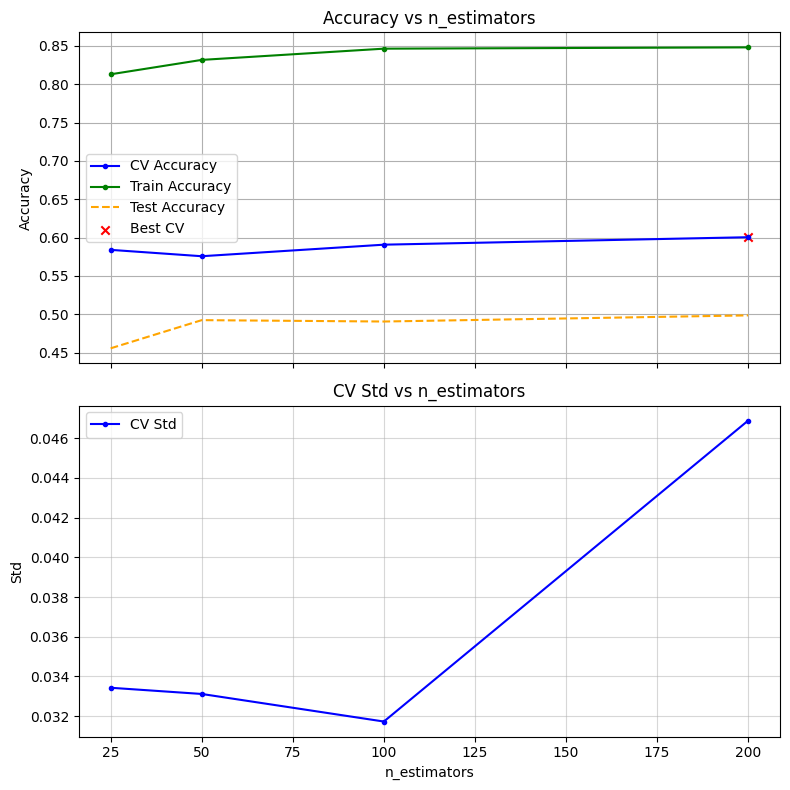

Execution Time: 00:00:08


Sweeping max_samples: 100%|██████████| 6/6 [00:10<00:00,  1.76s/it]


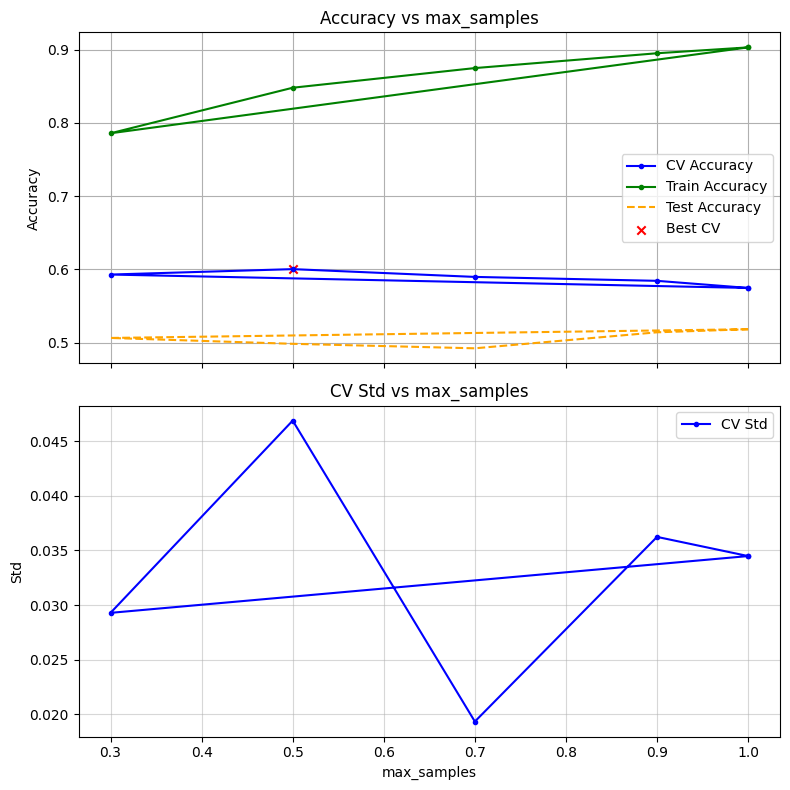

Execution Time: 00:00:10


Sweeping max_features: 100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


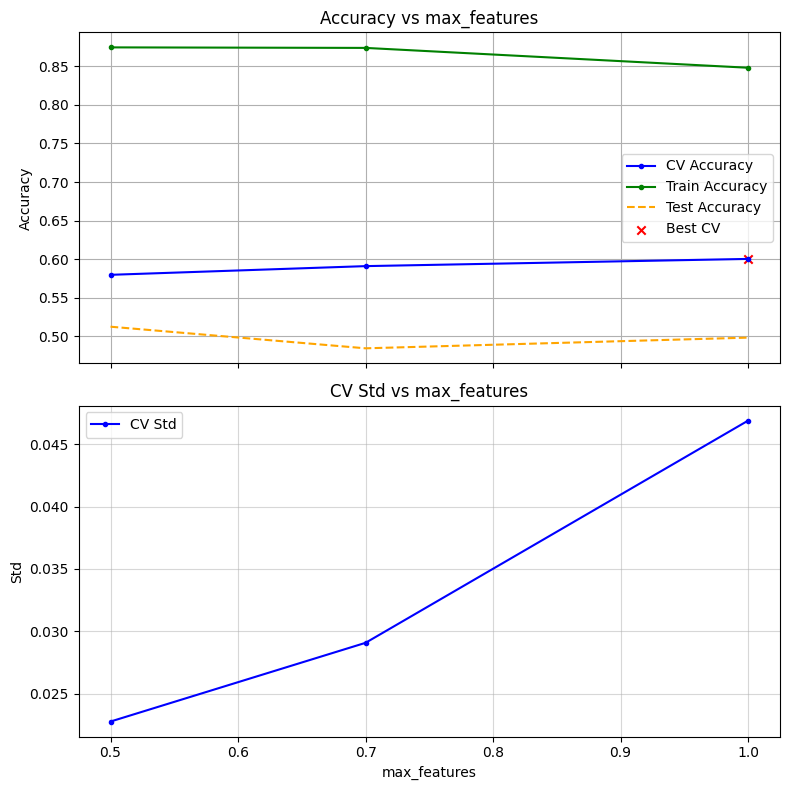

Execution Time: 00:00:04


Sweeping replacement: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


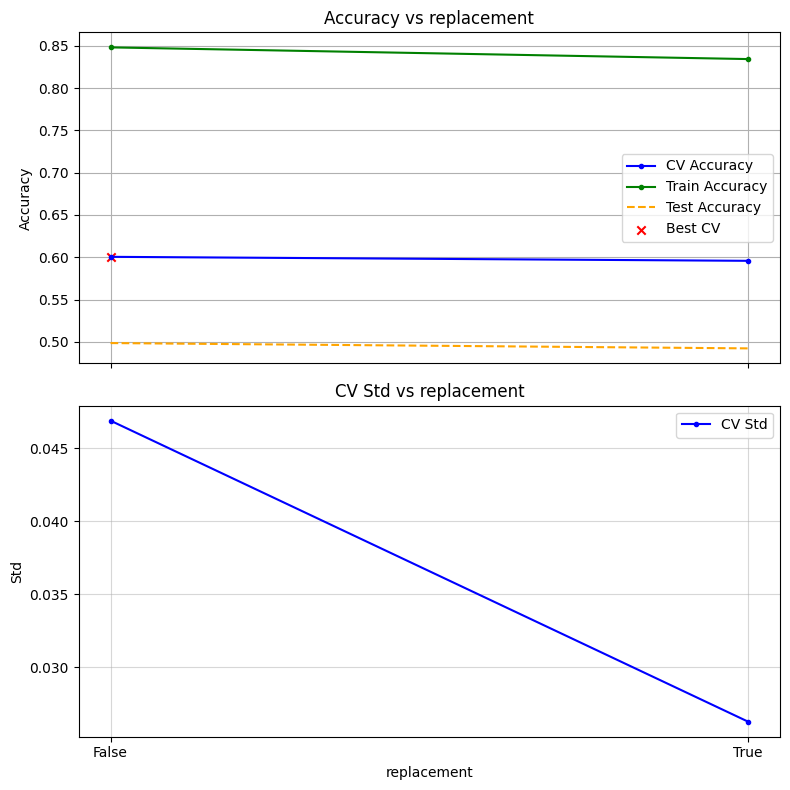

Execution Time: 00:00:02


Sweeping sampling_strategy: 100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


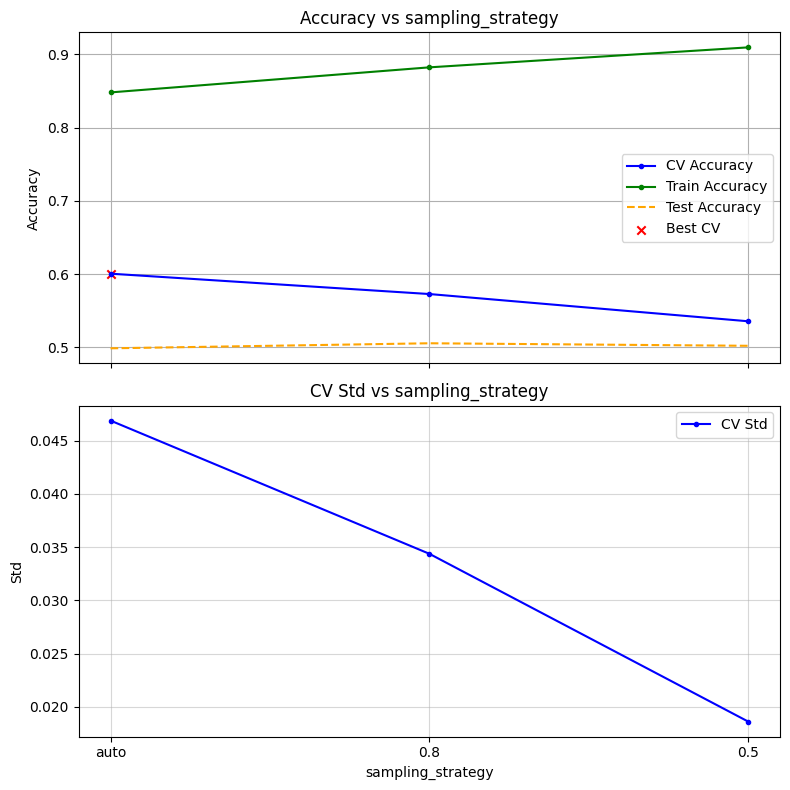

Execution Time: 00:00:05


,estimator,n_estimators,max_samples,max_features,bootstrap,bootstrap_features,oob_score,warm_start,sampling_strategy,replacement,n_jobs,random_state,verbose,sampler,accuracy_found
0,None,200,0.5,1.0,True,False,False,False,auto,False,None,42,0,None,0.600474
1,None,200,0.5,1.0,True,False,False,False,auto,False,None,42,0,None,0.600474


In [87]:
frac_samples = [0.3, 0.5, 0.7, 0.9, 1.0]
frac_features = [0.5, 0.7, 1.0]

parameters_and_ranges = [
    # Decision Tree Estimator Knobs
    ('n_estimators',               [25, 50, 100, 200]),
    # Bagging and Sampling Knobs
    ('max_samples',                [1.0] + frac_samples),  # None = use all (bootstrap logic applies)
    ('max_features',               frac_features),
    ('replacement',                [False, True]),
    ('sampling_strategy',        ['auto', 0.8, 0.5]),
]

for param, parameter_list in parameters_and_ranges:
    Parameters_BBC = sweep_parameter(
        BalancedBaggingClassifier,      # or your model class
        Parameters_BBC,          # renamed variable here
        param,
        parameter_list,
        X_train=bdb_X_train_scaled,
        y_train=bdb_y_train,
        X_test=bdb_X_test_scaled,
        y_test=bdb_y_test,
        n_jobs=-1,
        n_repeats=2
    )

Params_BBC_List.append(Parameters_BBC)
pd.DataFrame(Params_BBC_List)

Hmm, didn't seem to move the needle at all. Let's iterate on the other hyperparameters some more: 

Sweeping replacement: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


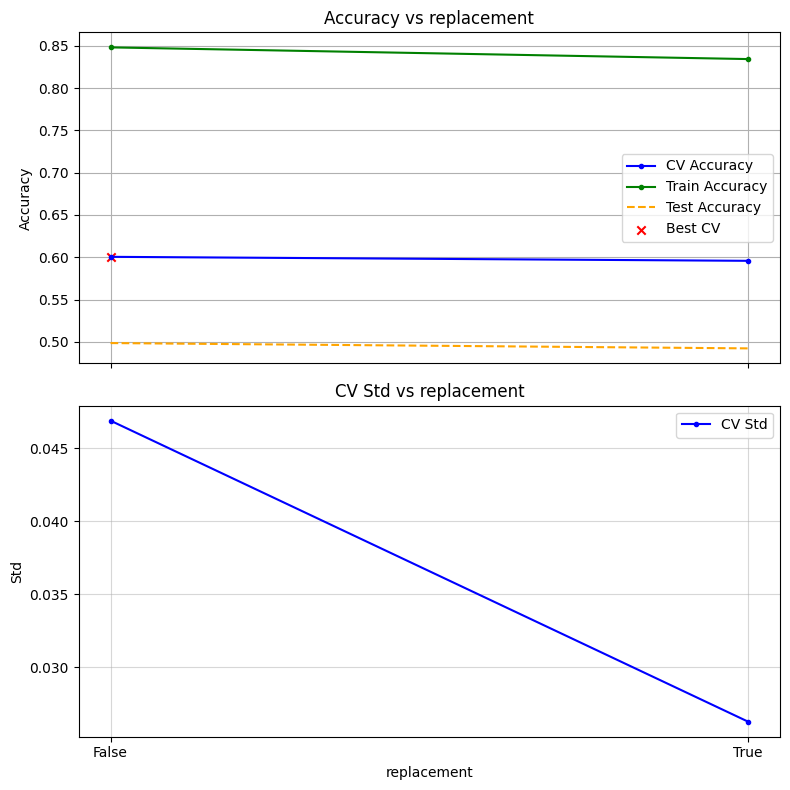

Execution Time: 00:00:02


Sweeping sampling_strategy: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


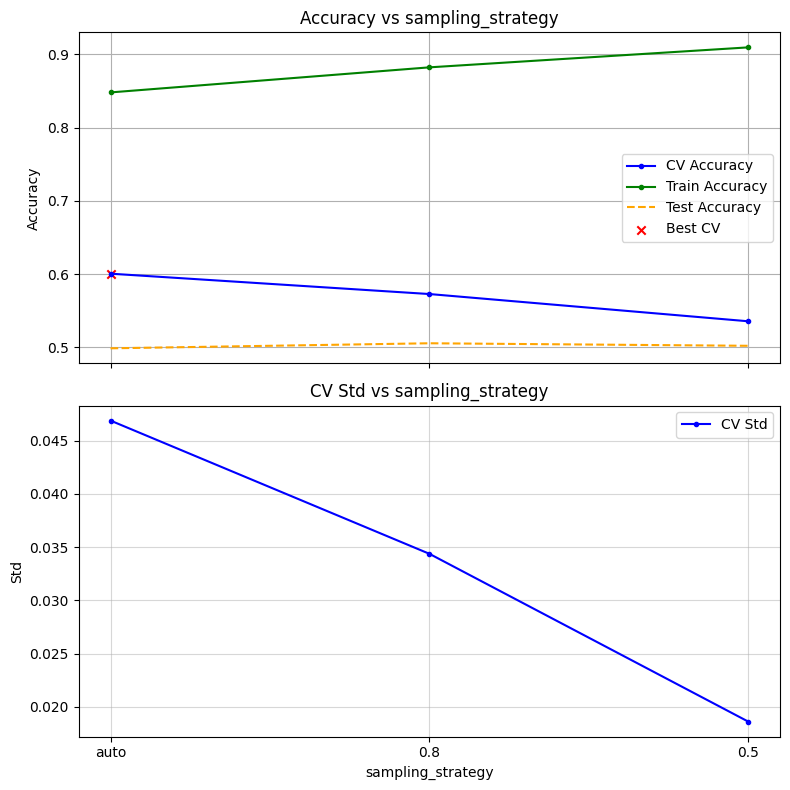

Execution Time: 00:00:04


Sweeping bootstrap: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


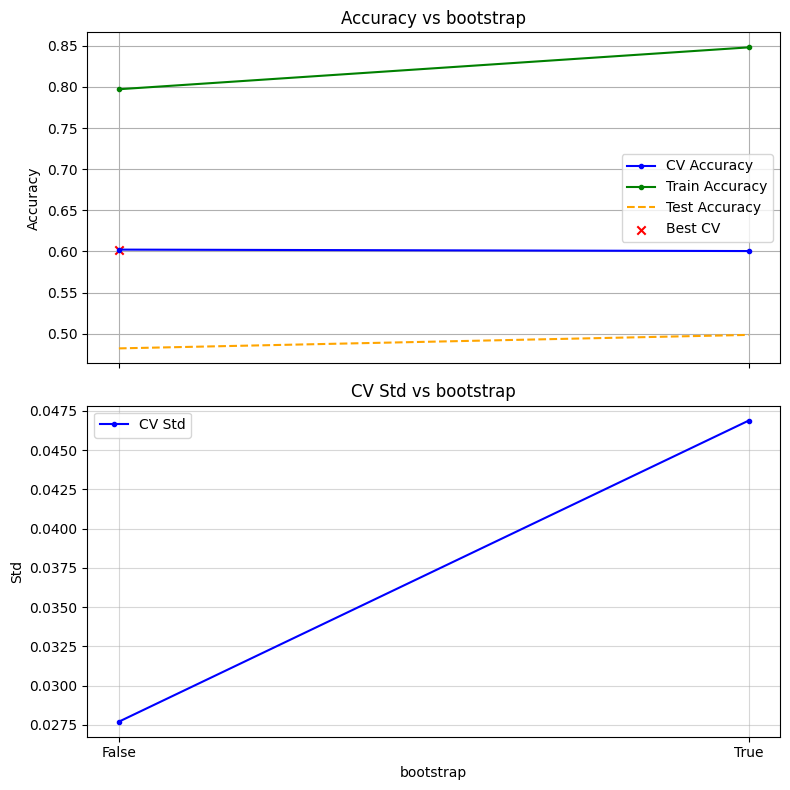

Execution Time: 00:00:02


,estimator,n_estimators,max_samples,max_features,bootstrap,bootstrap_features,oob_score,warm_start,sampling_strategy,replacement,n_jobs,random_state,verbose,sampler,accuracy_found
0,None,200,0.5,1.0,True,False,False,False,auto,False,None,42,0,None,0.600474
1,None,200,0.5,1.0,True,False,False,False,auto,False,None,42,0,None,0.600474
2,None,200,0.5,1.0,False,False,False,False,auto,False,None,42,0,None,0.602228


In [89]:
frac_samples = [0.3, 0.5, 0.7, 0.9, 1.0]
frac_features = [0.5, 0.7, 1.0]

parameters_and_ranges = [
    # Decision Tree Estimator Knobs
    # Bagging and Sampling Knobs
    ('replacement',                [False, True]),
    ('sampling_strategy',        ['auto', 0.8, 0.5]),
    ('bootstrap',               [False, True]),
]

for param, parameter_list in parameters_and_ranges:
    Parameters_BBC = sweep_parameter(
        BalancedBaggingClassifier,      # or your model class
        Parameters_BBC,          # renamed variable here
        param,
        parameter_list,
        X_train=bdb_X_train_scaled,
        y_train=bdb_y_train,
        X_test=bdb_X_test_scaled,
        y_test=bdb_y_test,
        n_jobs=-1,
        n_repeats=2
    )

Params_BBC_List.append(Parameters_BBC)
pd.DataFrame(Params_BBC_List)

In [91]:
params_ = {
    'n_estimators' : 200,  
    'max_samples' : 0.5,
    'max_features' : 1.0,
    'sampling_strategy': 'auto',
    'replacement': True, 
    'random_state' : 42,
}

BBC_Tuned = run_model_classifier(
    BalancedBaggingClassifier,
    bdb_X_train_scaled, 
    bdb_y_train, 
    bdb_X_test_scaled,
    bdb_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB - BBC - Tuned', 
    return_model=False,
    concat_results=False,
    **params_
    )

BBC_Tuned

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,BalancedBaggingClassifier,"{'bootstrap': True, 'bootstrap_features': Fals...",0.698464,0.016002,0.704928,0.675439,0.834308,0.492216,BDB - BBC - Tuned


### **Imbalanced Random Forest Classifier**

In [100]:
# ===============================================================================================
# From Module 3 Week 8: 
# link: https://github.com/waysnyder/Module-3-Assignments/blob/main/Homework_08.ipynb
# ===============================================================================================

def sweep_parameter(
    model,
    Parameters,
    param,
    parameter_list,
    *,
    X_train,
    y_train,
    X_test,
    y_test,
    verbose=True,
    n_iter_no_change=None,
    delta=0.001,
    n_jobs=-1,
    n_repeats=10,
):
    import time
    import numpy as np
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    start = time.time()
    Parameters = Parameters.copy()  # don’t mutate caller’s dict

    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf

    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        P_temp = Parameters.copy()
        P_temp[param] = p
        P_temp.pop('accuracy_found', None)
        P_temp.pop('n_jobs', None)
        P_temp.pop('estimator', None)
        P_temp.pop('bootstrap_features', None)
        P_temp.pop('sampler', None)

        # run_model should return: mean_cv, std_cv, train_acc, test_acc
        mean_cv, std_cv, train_acc, test_acc = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )

        cv_accuracies.append(mean_cv)
        std_cvs.append(std_cv)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if mean_cv > best_accuracy + delta:
            best_accuracy = mean_cv
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            if verbose:
                print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy

    if verbose:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

        partial_param_list = parameter_list[:len(cv_accuracies)]
        is_boolean = all(isinstance(v, bool) for v in partial_param_list)
        x_vals = list(range(len(partial_param_list))) if is_boolean else partial_param_list
        x_labels = [str(v) for v in partial_param_list]

        ax1.set_title(f"Accuracy vs {param}")
        ax1.plot(x_vals, cv_accuracies, marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals, train_accuracies, marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals, test_accuracies, linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]], [max_cv_accuracy], marker='x', label="Best CV", color='red')
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()

        ax2.set_title(f"CV Std vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Std")
        ax2.legend()
        ax2.grid(alpha=0.5)
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters

In [93]:
Default_Parameters_BalancedRF = {
    'n_estimators'            : 100,        # number of trees
    'criterion'               : 'gini',     # 'gini' or 'entropy' (or 'log_loss' in newer sklearn)
    'max_depth'               : None,       # tree depth
    'min_samples_split'       : 2,
    'min_samples_leaf'        : 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features'            : 'sqrt',     # features considered per split
    'max_leaf_nodes'          : None,
    'min_impurity_decrease'   : 0.0,
    'bootstrap'               : True,       # BRF inherits RF bootstrapping
    'oob_score'               : False,
    'n_jobs'                  : -1,         # model’s own parallelism (see note below)
    'random_state'            : 42,
    'verbose'                 : 0,
    'warm_start'              : False,
    'class_weight'            : None,       # usually leave None; balancing is handled by BRF sampler
    'ccp_alpha'               : 0.0,
    'max_samples'             : None,       # if bootstrap=True: None|int|float in (0,1]
    # BRF-specific balancing knobs:
    'sampling_strategy'       : 'auto',     # how to balance each bootstrap sample
    'replacement'             : False,      # class-wise resampling with/without replacement
}

In [94]:
Parameters_BRFC = Default_Parameters_BalancedRF.copy()
Params_BRFC_List = []

Sweeping replacement: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


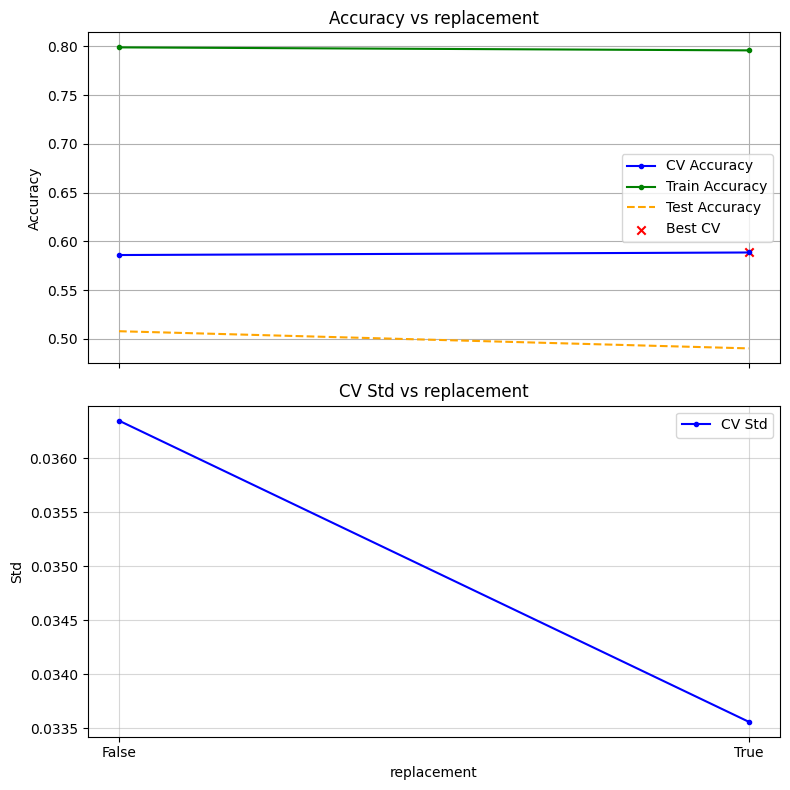

Execution Time: 00:00:04


Sweeping sampling_strategy: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


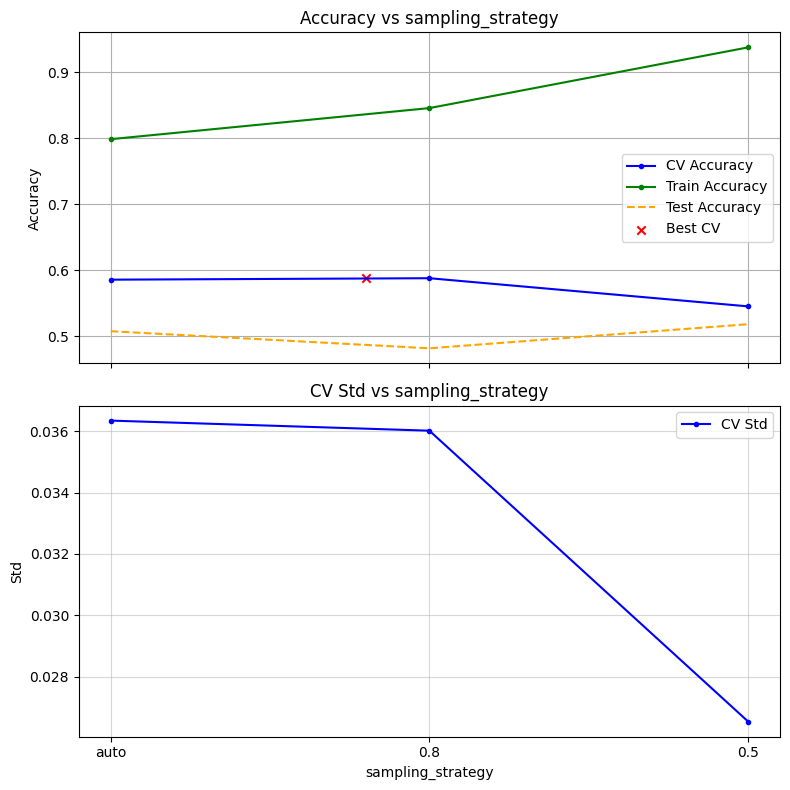

Execution Time: 00:00:04


Sweeping bootstrap: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


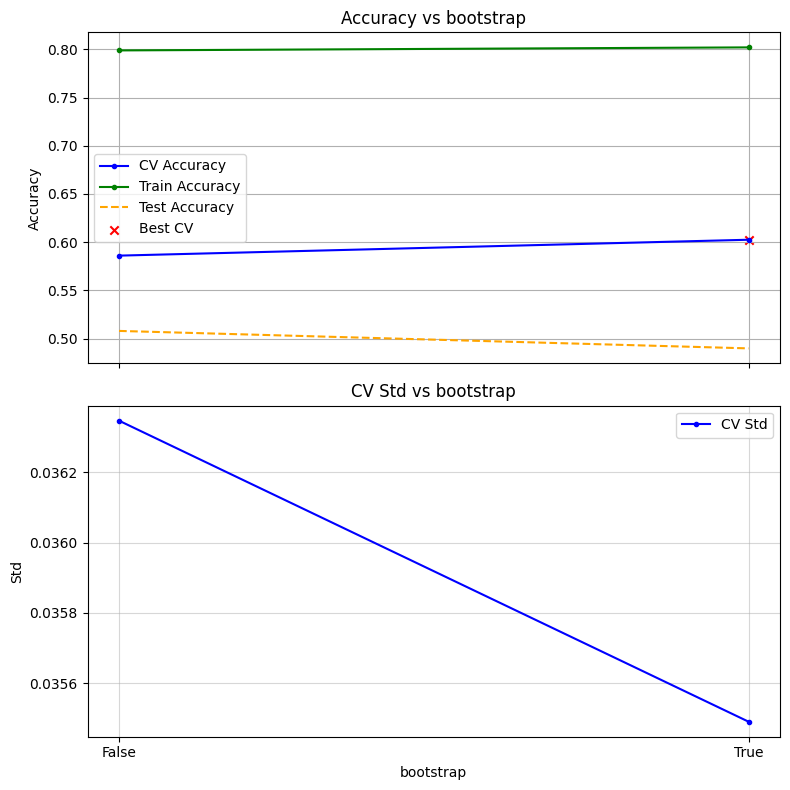

Execution Time: 00:00:02


,estimator,n_estimators,max_samples,max_features,bootstrap,bootstrap_features,oob_score,warm_start,sampling_strategy,replacement,n_jobs,random_state,verbose,sampler,accuracy_found
0,None,200,0.5,1.0,True,False,False,False,auto,False,None,42,0,None,0.602505


In [101]:
# Fractions for row & feature subsampling
frac_samples  = [None, 0.5, 0.7, 0.9, 1.0]   # None = use all (valid for BRF/RF)
frac_features = ['sqrt', 'log2', 0.5, 0.7, 1.0]

parameters_and_ranges_brf = [
    ('n_estimators',        [100, 200, 400]),
    ('max_depth',          [None, 8, 16, 24, 32]),
    ('min_samples_leaf',   [1, 2, 5, 10]),
    ('max_features',        frac_features),
    ('max_samples',         frac_samples),       # only used if bootstrap=True
    ('sampling_strategy',  ['auto', 0.8, 0.5]), # balance each bootstrap sample
    ('replacement',        [False, True]),
]

for param, parameter_list in parameters_and_ranges:
    Parameters_BRFC = sweep_parameter(
        BalancedRandomForestClassifier,      # or your model class
        Parameters_BBC,          # renamed variable here
        param,
        parameter_list,
        X_train=bdb_X_train_scaled,
        y_train=bdb_y_train,
        X_test=bdb_X_test_scaled,
        y_test=bdb_y_test,
        n_jobs=-1,
        n_repeats=2
    )

Params_BRFC_List.append(Parameters_BRFC)
pd.DataFrame(Params_BRFC_List) 

_____

## **Random Under Sampler Boost (RUSBOOSTClassifier)**

In [134]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score
import numpy as np

def run_model_classifier_rusboost_safe(
    model_cls,
    X_train, y_train, X_test, y_test,
    n_repeats=5, n_jobs=-1, run_comment="", return_model=False, concat_results=False,
    **params
):
    # ----- safer defaults for RUSBoost -----
    params = params.copy()
    if 'estimator' not in params or params['estimator'] is None:
        params['estimator'] = DecisionTreeClassifier(
            max_depth=3, min_samples_leaf=10, random_state=42
        )
    params.setdefault('n_estimators', 100)
    params.setdefault('learning_rate', 0.1)
    params.setdefault('sampling_strategy', 0.8)  # gentler than 'auto'
    params.setdefault('replacement', True)
    params.setdefault('random_state', 42)

    # ----- CV with failure tolerance -----
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    cv_scores = []
    for tr, va in cv.split(X_train, y_train):
        clf = model_cls(**params)
        try:
            clf.fit(X_train[tr], y_train[tr])
            pred = clf.predict(X_train[va])
            cv_scores.append(balanced_accuracy_score(y_train[va], pred))
        except Exception:
            # fold failed -> skip
            cv_scores.append(np.nan)

    if np.all(np.isnan(cv_scores)):
        mean_cv, std_cv = -np.inf, 0.0
    else:
        mean_cv = float(np.nanmean(cv_scores))
        # sample std over non-nan folds
        good = np.array([s for s in cv_scores if not np.isnan(s)])
        std_cv = float(np.std(good, ddof=1)) if good.size > 1 else 0.0

    # ----- Fit once on full train (also tolerant) -----
    try:
        final = model_cls(**params)
        final.fit(X_train, y_train)
        train_bal = balanced_accuracy_score(y_train, final.predict(X_train))
        test_bal  = balanced_accuracy_score(y_test,  final.predict(X_test))
    except Exception:
        train_bal, test_bal = np.nan, np.nan
        final = None

    # match your return pattern (mean_cv, std_cv, train_acc, test_acc),
    # but here we return balanced accuracy throughout
    return mean_cv, std_cv, train_bal, test_bal

In [133]:
params_ = {
    'estimator'         : DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42),
    'n_estimators'      : 100,
    'learning_rate'     : 0.1,
    'sampling_strategy' : 0.8,
    'replacement'       : True,
    'random_state'      : 42,
}

BDB_RusBoost_Tuned = run_model_classifier(
    RUSBoostClassifier,
    bdb_X_train_scaled, 
    bdb_y_train, 
    bdb_X_test_scaled,
    bdb_y_test,
    n_repeats=5, 
    n_jobs=-1, 
    run_comment='BDB - RUS Boost - Tuned', 
    return_model=False,
    concat_results=False,
    **params_
    )

BDB_RusBoost_Tuned

/Users/leemcfarling/venvs/tfclean/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
3 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/leemcfarling/venvs/tfclean/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/leemcfarling/venvs/tfclean/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/leemcfarling/venvs/tfclean/lib/python3.12/site

,model,model_params,mean_cv_accuracy,std_cv_accuracy,train_accuracy,test_accuracy,balanced_train_accuracy,balanced_test_accuracy,run_comment
0,RUSBoostClassifier,"{'algorithm': 'deprecated', 'estimator__ccp_al...",NaN,NaN,0.940635,0.932749,0.548557,0.501946,BDB - RUS Boost - Tuned
